In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import datetime
import itertools

import tensorflow as tf
from tensorflow import keras

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/week3timeseries/submission.csv
/kaggle/input/week3timeseries/train.csv
/kaggle/input/week3timeseries/test.csv


In [2]:
def prepare_data(timeseries_data, n_features):
    X, y =[],[]
    for i in range(len(timeseries_data)):
    # find the end of this pattern
        end_ix = i + n_features
        # check if we are beyond the sequence
        if end_ix > len(timeseries_data)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [3]:
df_train = pd.read_csv('../input/week3timeseries/train.csv')
df_test = pd.read_csv('../input/week3timeseries/test.csv')
sample = pd.read_csv('../input/week3timeseries/submission.csv')

In [4]:
df_train.tail()

,WeekEnding_Date,Kolkata_Average_Price,Kolkata_Ref_Price,Bangalore_Average_Price,Bangalore_Ref_Price,Cochin_Average_Price,Cochin_Ref_Price,Darjeeling_Average_Price,Darjeeling_Ref_Price,Ernakulam_Average_Price,Ernakulam_Ref_Price,Siliguri_Average_Price,Siliguri_Ref_Price,Guwahati_Average_Price,Guwahati_Ref_Price,Average
539,11/05/19,152.57,165.65,134.76,146.06,149.81,134.17,122.98,115.81,98.29,81.65,109.36,94.33,89.81,70.66,118.993571
540,18/05/19,147.74,159.89,134.5,146.36,148.81,142.88,122.98,113,96.47,78.46,111.36,90.39,90.96,66.68,117.891429
541,25/05/19,149.69,155.28,134.29,142.67,147.25,149.11,122.78,111.2,94.61,77.33,109.2,92.87,87.72,66.49,117.177857
542,01/06/19,144.51,150.81,138.45,151.35,149.7,151.4,122.82,111.12,93.01,77.14,109.69,91.66,86.6,68,117.590000
543,08/06/19,151.61,156.67,146.91,153.37,147.83,145.44,120.12,112.83,92.16,76.98,105.16,91.57,84.63,67.13,118.029286


In [5]:
df_train.columns[df_train.isnull().any()]

Index(['Kolkata_Ref_Price', 'Bangalore_Ref_Price', 'Cochin_Ref_Price',
       'Darjeeling_Ref_Price', 'Ernakulam_Ref_Price', 'Siliguri_Average_Price',
       'Siliguri_Ref_Price'],
      dtype='object')

In [6]:
df_train.shape,df_test.shape

((544, 16), (29, 16))

In [7]:
df_test['WeekEnding_Date'] = pd.to_datetime(df_test['WeekEnding_Date'],format='%d/%m/%y')

In [8]:
df_train['date'] = df_train['WeekEnding_Date']
#df_train['date'] = df_train['date'].astype(int)

In [9]:
df_train['delta'] = pd.to_datetime(df_train['WeekEnding_Date'],format='%d/%m/%y')-pd.to_datetime(df_train['WeekEnding_Date'],format='%d/%m/%y').shift(1)

In [10]:
len(df_train.loc[df_train['delta']!='7 days'])

12

In [11]:
df_train.loc[df_train['delta']!='7 days']

,WeekEnding_Date,Kolkata_Average_Price,Kolkata_Ref_Price,Bangalore_Average_Price,Bangalore_Ref_Price,Cochin_Average_Price,Cochin_Ref_Price,Darjeeling_Average_Price,Darjeeling_Ref_Price,Ernakulam_Average_Price,Ernakulam_Ref_Price,Siliguri_Average_Price,Siliguri_Ref_Price,Guwahati_Average_Price,Guwahati_Ref_Price,Average,date,delta
0,03/01/09,99.01,79.79,N.S.,76.19,84.02,70.07,81.66,57.83,68.94,51.67,70.74,53.88,65.55,46.75,69.700000,03/01/09,NaT
93,13/10/10,N.S.,128.85,124.62,119.67,106.5,108.25,84.58,86.17,63.59,72.49,65.61,75.68,52.14,67.16,88.870000,13/10/10,4 days
94,16/10/10,133.76,130.14,N.S.,119.69,N.S.,106.18,85.06,N.S.,63.41,73.67,66.86,N.S.,50.36,68.14,89.727000,16/10/10,3 days
95,30/10/10,133.73,132.56,122.23,119.64,108.24,109.63,83.39,82.58,64.65,68.75,66.65,72.78,51.42,65.26,91.536429,30/10/10,14 days
220,16/03/13,N.S.,N.S.,N.S.,N.S.,N.S.,79.96,124.3,90.21,107.93,71.83,111.6,72.88,94.41,64.77,90.876667,16/03/13,0 days
259,21/12/13,143.51,145.3,118.65,133.74,120.28,126.51,98.56,103.74,73.19,97.88,80.38,96.88,76.66,99.46,108.195714,21/12/13,14 days
470,07/01/18,143.37,142.07,132.49,123.86,129.67,123.5,109.9,112.85,88.1,108.25,92.71,106.49,67.23,99.02,112.822143,07/01/18,8 days
472,20/01/18,131.26,138.95,120.58,118.2,123.34,113.58,117.92,119.11,87.08,106.54,97.97,108.3,69.97,100.75,110.967857,20/01/18,6 days
483,04/04/18,175.72,154.56,162.69,156.27,142.63,127.64,119.11,106.82,83.83,73.75,94.03,83.33,65.59,62.51,114.891429,04/04/18,4 days
484,07/04/18,119.74,115,125.75,130.71,165.07,144.27,122.63,137.25,94.16,105.81,107.07,110.9,67.93,98.26,117.467857,07/04/18,3 days


In [12]:
df_train['date']=df_train['date'].replace('13/10/10','23/10/10')
df_train['date']=df_train['date'].replace('07/01/18','06/01/18')
df_train['date']=df_train['date'].replace('14/01/18','13/01/18')
df_train.drop(index=[220,483],axis=0,inplace=True)

In [13]:
dates = ['14/12/13','04/08/18','03/11/18']
for i in range(len(dates)):
    d = dates[i]
    df_train = df_train.append({'date':d},ignore_index=True)

In [14]:
df_train['WeekEnding_Date'] = pd.to_datetime(df_train['date'],format='%d/%m/%y',dayfirst=True,infer_datetime_format=False)
df_test['WeekEnding_Date'] = pd.to_datetime(df_test['WeekEnding_Date'],format='%d/%m/%y',dayfirst=True,infer_datetime_format=False)

In [15]:
df_train['WeekEnding_Date'].head(),df_test['WeekEnding_Date'].head()

(0   2009-01-03
 1   2009-01-10
 2   2009-01-17
 3   2009-01-24
 4   2009-01-31
 Name: WeekEnding_Date, dtype: datetime64[ns],
 0   2019-06-15
 1   2019-06-22
 2   2019-06-29
 3   2019-07-06
 4   2019-07-13
 Name: WeekEnding_Date, dtype: datetime64[ns])

In [16]:
df_train.tail()

,WeekEnding_Date,Kolkata_Average_Price,Kolkata_Ref_Price,Bangalore_Average_Price,Bangalore_Ref_Price,Cochin_Average_Price,Cochin_Ref_Price,Darjeeling_Average_Price,Darjeeling_Ref_Price,Ernakulam_Average_Price,Ernakulam_Ref_Price,Siliguri_Average_Price,Siliguri_Ref_Price,Guwahati_Average_Price,Guwahati_Ref_Price,Average,date,delta
540,2019-06-01,144.51,150.81,138.45,151.35,149.7,151.4,122.82,111.12,93.01,77.14,109.69,91.66,86.6,68,117.590000,01/06/19,7 days
541,2019-06-08,151.61,156.67,146.91,153.37,147.83,145.44,120.12,112.83,92.16,76.98,105.16,91.57,84.63,67.13,118.029286,08/06/19,7 days
542,2013-12-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14/12/13,NaT
543,2018-08-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04/08/18,NaT
544,2018-11-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,03/11/18,NaT


In [17]:
df_train['WeekEnding_Date'] = pd.to_datetime(df_train['date'],format='%d/%m/%y',dayfirst=True,infer_datetime_format=False)
df_train['WeekEnding_Date'].tail()

540   2019-06-01
541   2019-06-08
542   2013-12-14
543   2018-08-04
544   2018-11-03
Name: WeekEnding_Date, dtype: datetime64[ns]

In [18]:
df_train = df_train.sort_values('WeekEnding_Date',ignore_index=True)

In [19]:
df_train

,WeekEnding_Date,Kolkata_Average_Price,Kolkata_Ref_Price,Bangalore_Average_Price,Bangalore_Ref_Price,Cochin_Average_Price,Cochin_Ref_Price,Darjeeling_Average_Price,Darjeeling_Ref_Price,Ernakulam_Average_Price,Ernakulam_Ref_Price,Siliguri_Average_Price,Siliguri_Ref_Price,Guwahati_Average_Price,Guwahati_Ref_Price,Average,date,delta
0,2009-01-03,99.01,79.79,N.S.,76.19,84.02,70.07,81.66,57.83,68.94,51.67,70.74,53.88,65.55,46.75,69.700000,03/01/09,NaT
1,2009-01-10,97.74,78.73,87.48,73.97,82.72,68.17,83.31,58.02,67.24,52.23,70.47,53.39,67.39,46.84,70.550000,10/01/09,7 days
2,2009-01-17,95.95,71.01,87.66,71.01,80.58,67.16,82.25,57.49,69.64,52.48,71.66,53.18,69.51,48.04,69.830000,17/01/09,7 days
3,2009-01-24,94.14,73.38,85.69,65.66,N.S.,65.57,80.87,54.59,N.S.,53.43,71.12,52.07,69.14,48.5,67.846667,24/01/09,7 days
4,2009-01-31,91.45,70.39,N.S.,64.99,79.27,62.09,80.76,57.06,69.65,53.38,72.3,52.5,69.39,50.33,67.196923,31/01/09,7 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,2019-05-11,152.57,165.65,134.76,146.06,149.81,134.17,122.98,115.81,98.29,81.65,109.36,94.33,89.81,70.66,118.993571,11/05/19,7 days
541,2019-05-18,147.74,159.89,134.5,146.36,148.81,142.88,122.98,113,96.47,78.46,111.36,90.39,90.96,66.68,117.891429,18/05/19,7 days
542,2019-05-25,149.69,155.28,134.29,142.67,147.25,149.11,122.78,111.2,94.61,77.33,109.2,92.87,87.72,66.49,117.177857,25/05/19,7 days
543,2019-06-01,144.51,150.81,138.45,151.35,149.7,151.4,122.82,111.12,93.01,77.14,109.69,91.66,86.6,68,117.590000,01/06/19,7 days


In [20]:
df_train['delta'] = pd.to_datetime(df_train['WeekEnding_Date'],format='%d/%m/%y')-pd.to_datetime(df_train['WeekEnding_Date'],format='%d/%m/%y').shift(1)
df_train[df_train['delta']!='7 days']

,WeekEnding_Date,Kolkata_Average_Price,Kolkata_Ref_Price,Bangalore_Average_Price,Bangalore_Ref_Price,Cochin_Average_Price,Cochin_Ref_Price,Darjeeling_Average_Price,Darjeeling_Ref_Price,Ernakulam_Average_Price,Ernakulam_Ref_Price,Siliguri_Average_Price,Siliguri_Ref_Price,Guwahati_Average_Price,Guwahati_Ref_Price,Average,date,delta
0,2009-01-03,99.01,79.79,N.S.,76.19,84.02,70.07,81.66,57.83,68.94,51.67,70.74,53.88,65.55,46.75,69.7,03/01/09,NaT


In [21]:
print(df_train.Average.isnull().sum())
df_train.Average.head()

3


0    69.700000
1    70.550000
2    69.830000
3    67.846667
4    67.196923
Name: Average, dtype: float64

In [22]:
df_train['Average'] = df_train['Average'].interpolate(method='linear',limit_direction='both')
df_train.Average.head()

0    69.700000
1    70.550000
2    69.830000
3    67.846667
4    67.196923
Name: Average, dtype: float64

<AxesSubplot:xlabel='WeekEnding_Date', ylabel='Average'>

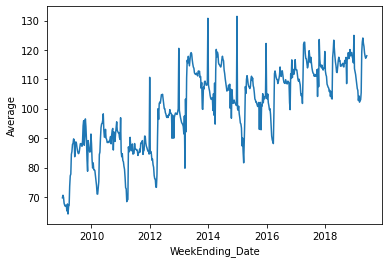

In [23]:
sns.lineplot(x='WeekEnding_Date',y='Average',data=df_train)

df_train['logaverage'] = np.log(df_train['Average'])
df_train['shiftaverage'] = df_train['Average'] - df_train['Average'].shift(1)

sns.lineplot(x='WeekEnding_Date',y='logaverage',data=df_train)

sns.lineplot(x='WeekEnding_Date',y='shiftaverage',data=df_train)

def sintheta(x):
    x = np.pi*x/180
    x = np.sin(x)
    return x

def sininv(x):
    x = np.arcsin(x)
    x = (x*180)/np.pi
    return x

df_train['sin_average'] = df_train['Average'].apply(lambda x : sintheta(x))

df_train['sin_average'] 

In [24]:
fig = px.line(x=df_train['WeekEnding_Date'],y=df_train['Average'])
fig.show()

df_train.loc[(df_train['shiftaverage']>20) | (df_train['shiftaverage']<-20)]

In [25]:
fig = px.line(x=df_train['WeekEnding_Date'],y=df_train['Average'])
fig.show()

In [27]:
train = df_train[:-20]
valid = df_train[-20:]

In [28]:
ar = 2
ma = (1,0,0,1)
arima_model = SARIMAX(train['Average'], order = (ar,1,ma), seasonal_order = (2,1,1,52))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                   Average   No. Observations:                  525
Model:             SARIMAX(2, 1, [1, 4])x(2, 1, [1], 52)   Log Likelihood               -1235.184
Date:                                   Thu, 19 Aug 2021   AIC                           2486.368
Time:                                           15:30:25   BIC                           2519.623
Sample:                                                0   HQIC                          2499.449
                                                   - 525                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1211      0.157      0.772      0.440      -0.186       0.429
ar.L2          0.1470      0.109      1.343      0.179      -0.068       0.362
ma.L1         -0.7527      0.153     -4.934      0.000      -1.052      -0.454
ma.L4          0.0549      0.061      0.899      0.369      -0.065       0.175
ar.S.L52      -0.7153      0.061    -11.649      0.000      -0.836      -0.595
ar.S.L104     -0.4441      0.028    -15.874      0.000      -0.499      -0.389
ma.S.L52       0.5994      0.077      7.778      0.000       0.448       0.750
sigma2        10.3352      0.397     26.001      0.000       9.556      11.114
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               914.81
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.77
Prob(H) (two-sided):                  0.27   Kurtosis:                         9.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
arima_pred = arima_result.predict(start = len(train), end = len(df_train)-1, typ="levels").rename("ARIMA Predictions")
y = valid['Average']
rsme = np.sqrt(mean_squared_error(y,arima_pred))
print(rsme)

2.103701677573499


In [30]:
arima_model = SARIMAX(df_train['Average'], order = (2,0,2), seasonal_order = (2,1,1,52))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                              Average   No. Observations:                  545
Model:             SARIMAX(2, 0, 2)x(2, 1, [1], 52)   Log Likelihood               -1281.622
Date:                              Thu, 19 Aug 2021   AIC                           2579.244
Time:                                      15:32:24   BIC                           2612.848
Sample:                                           0   HQIC                          2592.438
                                              - 545                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2720      0.324      0.840      0.401      -0.362       0.906
ar.L2          0.7066      0.322      2.194      0.028       0.076       1.338
ma.L1          0.0829      0.330      0.251      0.802      -0.564       0.730
ma.L2         -0.3689      0.217     -1.699      0.089      -0.794       0.057
ar.S.L52      -0.6794      0.064    -10.674      0.000      -0.804      -0.555
ar.S.L104     -0.4444      0.026    -17.001      0.000      -0.496      -0.393
ma.S.L52       0.5513      0.079      6.961      0.000       0.396       0.707
sigma2        10.0141      0.370     27.080      0.000       9.289      10.739
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              1077.43
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.82
Prob(H) (two-sided):                  0.07   Kurtosis:                        10.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
arima_pred = arima_result.predict(start = len(df_train), end = len(df_train)+28, typ="levels").rename("Average")
arima_pred

545    121.005964
546    120.860269
547    120.179408
548    120.492116
549    119.548137
550    119.046638
551    119.024188
552    119.171302
553    119.299339
554    118.522256
555    118.797151
556    120.195409
557    120.589779
558    119.448045
559    121.105258
560    116.970117
561    120.406971
562    116.830724
563    117.498880
564    120.821902
565    121.851280
566    125.241427
567    121.124287
568    122.528027
569    122.303396
570    120.976851
571    120.636012
572    119.427366
573    126.292428
Name: Average, dtype: float64

In [32]:
submission = pd.Series(arima_pred,index=None,name="Average")
submission.to_csv("Submission_week3_timeseries.csv")

## Prophet by Facebook

**Prophet** particularly requires dataset to be in a prerequisite format, first "Dates" specified in the column named as "ds" and target column as "y". Any deviations will be only throwing an Error. So, below we create a dataframe suitable for **Prophet**.

In [33]:
time_data = pd.DataFrame({"ds":df_train['WeekEnding_Date'],"y":df_train['Average']})

In [34]:
time_data.head(),time_data.tail()

(          ds          y
 0 2009-01-03  69.700000
 1 2009-01-10  70.550000
 2 2009-01-17  69.830000
 3 2009-01-24  67.846667
 4 2009-01-31  67.196923,
             ds           y
 540 2019-05-11  118.993571
 541 2019-05-18  117.891429
 542 2019-05-25  117.177857
 543 2019-06-01  117.590000
 544 2019-06-08  118.029286)

In [35]:
train = time_data[:520]
valid = time_data[520:]

In [36]:
train.tail

<bound method NDFrame.tail of             ds           y
0   2009-01-03   69.700000
1   2009-01-10   70.550000
2   2009-01-17   69.830000
3   2009-01-24   67.846667
4   2009-01-31   67.196923
..         ...         ...
515 2018-11-17  117.985000
516 2018-11-24  118.882857
517 2018-12-01  119.158571
518 2018-12-08  117.640000
519 2018-12-15  117.004286

[520 rows x 2 columns]>

In [37]:
valid.y.values

array([115.6321429, 124.975    , 113.645    , 112.7142857, 111.6864286,
       110.0264286, 108.5871429, 106.8621429, 106.2735714, 102.8115385,
       104.3761538, 102.24     , 102.8288889, 103.0572727, 105.4718182,
       119.3157143, 122.7185714, 124.08     , 122.2528571, 121.1528571,
       118.9935714, 117.8914286, 117.1778571, 117.59     , 118.0292857])

In [38]:
model = Prophet(
    #interval_width = 0.99,
   #daily_seasonality = True,
   # weekly_seasonality = True,
    yearly_seasonality = True,
    changepoint_prior_scale = 0.5,
    seasonality_prior_scale = 0.01
   #changepoints = df_filtered_changepoints['ds'],
    )

In [39]:
model.fit(train)

In [40]:
future = model.make_future_dataframe(periods = 25, freq = 'w')
forecast = model.predict(future)

In [41]:
forecast.yhat[-25:]

520    116.863122
521    119.661469
522    120.092523
523    117.526013
524    113.770232
525    111.142290
526    110.327448
527    110.261135
528    109.737254
529    108.585030
530    107.223967
531    105.702199
532    103.864037
533    102.445715
534    103.264003
535    107.610595
536    114.431729
537    120.616092
538    123.503995
539    123.095401
540    121.625201
541    121.087553
542    121.500780
543    121.630384
544    120.930836
Name: yhat, dtype: float64

In [42]:
rmse = np.sqrt(mean_squared_error(valid.y,forecast.yhat[-25:]))
print(rmse)

4.335802709792142


### Cross Validation with Prophet

In [43]:
from fbprophet.diagnostics import cross_validation, performance_metrics
#cutoffs = pd.to_datetime(['2013-02-15', '2013-08-15', '2014-02-15'])
param_grid = {  
    'changepoint_prior_scale': [0.01, 0.1, 0.25,0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5.0],
    'weekly_seasonality' : [False,True],
    'yearly_seasonality' : [True]
    
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results.sort_values('rmse')

,changepoint_prior_scale,seasonality_prior_scale,weekly_seasonality,yearly_seasonality,rmse
25,0.50,0.01,True,True,8.201075
24,0.50,0.01,False,True,8.218529
31,0.50,5.00,True,True,8.505792
27,0.50,0.10,True,True,8.509294
17,0.25,0.01,True,True,8.509533
16,0.25,0.01,False,True,8.524772
28,0.50,1.00,False,True,8.553340
29,0.50,1.00,True,True,8.560414
26,0.50,0.10,False,True,8.566496
30,0.50,5.00,False,True,8.572841


In [44]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True, 'yearly_seasonality': True}


In [45]:
future = m.make_future_dataframe(periods = 25, freq = 'w')
forecast = m.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


In [46]:
#fig1 = m.plot(forecast)

In [47]:
#fig2 = m.plot_components(forecast)


In [48]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [49]:
plot_components_plotly(m, forecast)

## LSTM

In [50]:
teaseries = df_train['Average']#.values.reshape(-1,1)

In [51]:
t_teaseries = teaseries[:-29]
v_teaseries = teaseries[-29:]

In [52]:
v_teaseries.shape

(29,)

In [53]:
#scaler = MinMaxScaler(feature_range=(-1,1))

In [54]:
#scaled = scaler.fit_transform(teaseries)

In [55]:
#scaled.shape

X_train = X[:(-20)]
X_valid = X[-20:]

In [56]:
n_steps = 4
X, y = prepare_data(t_teaseries,n_steps)

In [57]:
X.shape,y.shape

((512, 4), (512,))

In [58]:
n_features = 1
X = X.reshape(X.shape[0], X.shape[1], n_features)

In [59]:
X.shape

(512, 4, 1)

In [60]:
def tfrmse(y_true,y_pred):
    elements = ((y_true - y_pred)) ** 2
    elements = tf.reduce_sum(elements)/tf.cast(tf.size(y_pred),tf.float32)
    return tf.sqrt(elements)

In [61]:
terminate_onNaN = tf.keras.callbacks.TerminateOnNaN()
reducelronplateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor=0.1,patience=10,verbose=0,
                                     mode="min",min_delta=5.0,cooldown=0,min_lr=1e-6)

In [62]:
def build_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(100, activation='relu',return_sequences=True,kernel_initializer="he_normal", input_shape=(n_steps, n_features)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.LSTM(100,return_sequences=True, activation='tanh'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(128, activation='tanh'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [63]:
lstm_model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam")
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
lstm_model.compile(optimizer=optimizer, loss=tfrmse)

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4, 100)            40800     
_________________________________________________________________
dropout (Dropout)            (None, 4, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 100)            80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 100)            0         
_________________________________________________________________
dense (Dense)                (None, 4, 128)            12928     
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 128)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 4, 1)              1

In [64]:
lstm_model.fit(X,y,epochs=200,callbacks=[terminate_onNaN,reducelronplateau])

Epoch 1/200
16/16 [==============================] - 3s 11ms/step - loss: 91.8071
Epoch 2/200
16/16 [==============================] - 0s 11ms/step - loss: 65.4586
Epoch 3/200
16/16 [==============================] - 0s 10ms/step - loss: 45.0817
Epoch 4/200
16/16 [==============================] - 0s 11ms/step - loss: 26.6078
Epoch 5/200
16/16 [==============================] - 0s 11ms/step - loss: 16.6805
Epoch 6/200
16/16 [==============================] - 0s 11ms/step - loss: 16.0327
Epoch 7/200
16/16 [==============================] - 0s 10ms/step - loss: 15.6745
Epoch 8/200
16/16 [==============================] - 0s 11ms/step - loss: 15.6677
Epoch 9/200
16/16 [==============================] - 0s 11ms/step - loss: 14.8568
Epoch 10/200
16/16 [==============================] - 0s 11ms/step - loss: 16.1789
Epoch 11/200
16/16 [==============================] - 0s 11ms/step - loss: 15.3639
Epoch 12/200
16/16 [==============================] - 0s 11ms/step - loss: 15.6129
Epoch 13/200


x_input = np.array(v_teaseries)
temp_input=list(x_input)
lst_output=[]
i=0
while(i<29):
    
    if(len(temp_input)>n_steps):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, 28, n_features))
        #print(x_input)
        yhat = lstm_model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, 28, n_features))
        yhat = lstm_model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1
    

print(lst_output)

pred = np.array(lst_output)

In [ ]:
len(pred)

v = v_teaseries.values
v

rmse = np.sqrt(mean_squared_error(pred,v))

rmse

# End.